In [1]:
import requests
import os
import torch
import torchvision
import torchvision.transforms as transforms
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader



In [2]:
# set_numbers = [f'0{i}' for i in range(1,8)]
# card_numbers = [f'{i:03}' for i in range(1,120)]

In [3]:
# base_url = 'https://image.optcg.gg/images/en/'

# os.mkdir('C:\\Users\\Wayne Ewing\\Pictures\\card images\\')

In [4]:
# save_path = 'C:\\Users\\Wayne Ewing\\Pictures\\optcg_images'
# save_path


In [5]:
# os.mkdir('C:\\Users\\Wayne Ewing\\Pictures\\card images\\digimontcg_images')
# digimon_url = 'https://images.digimoncard.io/images/cards/'
# digi_save_path = 'C:\\Users\\Wayne Ewing\\Pictures\\card images\\digimontcg_images'

In [6]:
# digi_set = [f'{i}' for i in range(1,8)]
# digi_numbers = [f'{i:03}' for i in range(1,113)]

In [7]:
def pull_images(set_range,card_range,url,save_path):
    for set_num in set_range:
        for card_num in tqdm(card_range):
            #Change image url to fit file extension and tcg identifier
            image_url = f'{url}BT{set_num}-{card_num}.jpg'
        
            try:

                response = requests.get(image_url)
                response.raise_for_status()

                #Change image path to fit file extension and tcg identifier
                image_path = os.path.join(save_path,f'BT{set_num}-{card_num}.png')

                if response.status_code == 200:
                    with open(image_path, 'wb') as f:
                        f.write(response.content)
                else:
                    print(f"Image not found or failed to download: {image_url} (Status code: {response.status_code})")

            except requests.exceptions.HTTPError as err:
                print(f'Image not found: {image_url}')

In [8]:
def preprocess_image(image_path, output_path, size=(256, 256)):
    # print(image_path)
    image = cv.imread(image_path)

    #resize image
    resized_image = cv.resize(image,size,interpolation = cv.INTER_LINEAR)

    #normalizing image pixels
    resized_image = resized_image.astype('float32')/255.0

    normalized_image = (resized_image * 255).astype('uint8')

    # print(image)
    cv.imwrite(output_path, normalized_image)

def directory_resize(base_path,output_path,size=(256,256)):
    for file in tqdm(os.listdir(base_path)):
        preprocess_image(os.path.join(base_path,file),os.path.join(output_path,file),size)

In [9]:
digi_base_path = r'C:\Users\Wayne\OneDrive\Documents\GitHub\ComputerVision-Project\card_images\digimontcg_images'
op_base_path =  r'C:\Users\Wayne\OneDrive\Documents\GitHub\ComputerVision-Project\card_images\optcg_images'

digi_output_path = r'C:\Users\Wayne\OneDrive\Documents\GitHub\ComputerVision-Project\resized_images\resized_digimontcg_images'
op_output_path = r'C:\Users\Wayne\OneDrive\Documents\GitHub\ComputerVision-Project\resized_images\resized_optcg_images'

In [10]:
# directory_resize(digi_base_path,digi_output_path)
# directory_resize(op_base_path,op_output_path)

In [11]:
class TradingCardDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        # self.root_dir = root_dir
        self.transform = transform
        # self.classes = sorted(os.listdir(root_dir))
        self.image_paths = image_paths
        self.labels = labels

        # for label, class_name in enumerate(self.classes):
        #     class_dir = os.path.join(root_dir, class_name)
        #     for img_name in os.listdir(class_dir):
        #         img_path = os.path.join(class_dir, img_name)
        #         self.image_paths.append(img_path)
        #         self.labels.append(label)
        # self.train_paths, self.test_paths, self.train_labels, self.test_labels = train_test_split(self.image_paths, self.labels, test_size=0.2, random_state=42)     
        # self.train_paths, self.val_paths, self.train_labels, self.val_labels = train_test_split(self.train_paths, self.train_labels, test_size=0.25, random_state=42)  

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        print(f"Loaded image shape: {image.shape}")  # Print the shape of the image
        
        return image, label

In [12]:
root_dir = r'C:\Users\Wayne\OneDrive\Documents\GitHub\ComputerVision-Project\resized_images'
classes = sorted(os.listdir(root_dir))
image_paths = []
labels = []

for label, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image_paths.append(img_path)
        labels.append(label)

train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=42) 



In [13]:
transform = transforms.Compose([transforms.Resize((256,256)), 
                                transforms.ToTensor()])

In [23]:
train_dataset = TradingCardDataset(train_paths, train_labels, transform=transform)
val_dataset = TradingCardDataset(val_paths, val_labels)
test_dataset = TradingCardDataset(test_paths, test_labels)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [24]:
print(f"Number of images in train dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")

print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Batch size: {train_loader.batch_size}")

Number of images in train dataset: 969
Number of images in validation dataset: 324
Number of images in test dataset: 324
Number of batches in train loader: 969
Batch size: 1


Loaded image shape: torch.Size([3, 256, 256])


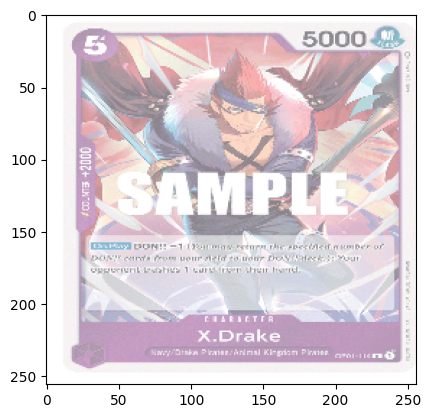

In [39]:
def imshow(img):
    img = img /2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))